In [1]:
from sklearn.datasets import fetch_openml

mnist=fetch_openml('mnist_784')
mnist.data[:5]

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
import numpy as np
X, y=mnist['data'], mnist['target']
y=y.astype(np.int)
print(X.shape, y.shape)

(70000, 784) (70000,)


<ipython-input-2-7926916c8ced>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y=y.astype(np.int)


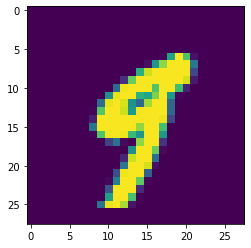

In [3]:
import matplotlib
import matplotlib.pyplot as plt

some_digit=X.values[36000]
some_digit_image=some_digit.reshape(28,28)
plt.imshow(some_digit_image)
plt.show()

9

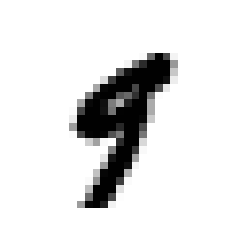

In [8]:
def plot_digit(data):
    image=data.reshape(28,28)
    plt.imshow(image, cmap=matplotlib.cm.binary)
    plt.axis('off')

plot_digit(X.values[36000])
y[36000]

In [9]:
X_train, X_test, y_train, y_test=X[:60000], X[60000:], y[:60000], y[60000:]

In [11]:
import numpy as np

shuffle_index=np.random.permutation(60000)
X_train, y_train=X_train.values[shuffle_index], y_train[shuffle_index]

In [12]:
# 이진 분류기
y_train_5=(y_train==5)
y_test_5=(y_test==5)

In [13]:
# 확률적 경사하강법 분류모형(온라인학습)
from sklearn.linear_model import SGDClassifier

sgd_clf=SGDClassifier(max_iter=1000, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [14]:
sgd_clf.predict([some_digit])

array([False])

In [15]:
# 교차검증
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9616 , 0.94255, 0.9638 ])

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
# 클래스 비율이 유지되는 교차검증
skfolds=StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf=clone(sgd_clf) # 분류모형을 복제 (데이터는 복제하지 않음)
    # 학습용, 검증용 구분
    X_train_folds=X_train[train_index]
    y_train_folds=y_train_5[train_index]
    X_test_folds=X_train[test_index]
    y_test_folds=y_train_5[test_index]
    clone_clf.fit(X_train_folds, y_train_folds) # 학습
    y_pred=clone_clf.predict(X_test_folds) # 분류
    n_correct=sum(y_pred==y_test_folds) # 정확도
    print(n_correct/len(y_pred))

0.9104
0.77795
0.83485


In [19]:
# 모든 예측 결과를 False로 리턴하는 테스트용 클래스
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool) # 2원 0배열(행의 수는 샘플 개수), 0을 False로 리턴

In [20]:
never_5_clf=Never5Classifier()
print(never_5_clf.predict(X_train))
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')
# 정확도가 높음 (이미지의 10%가 5이므로 5가 아니라고 분류하면 90% 정도의 정확도를 가짐)
# 이 모형은 좋은 모형은 아님, 특히 불균형 데이터셋의 경우 정확도는 큰 의미가 없을 수 있음

[[False]
 [False]
 [False]
 ...
 [False]
 [False]
 [False]]


array([0.9083 , 0.91175, 0.9089 ])

In [21]:
from sklearn.metrics import classification_report
print(classification_report(never_5_clf.predict(X_train), y_train_5))

              precision    recall  f1-score   support

       False       1.00      0.91      0.95     60000
        True       0.00      0.00      0.00         0

    accuracy                           0.91     60000
   macro avg       0.50      0.45      0.48     60000
weighted avg       1.00      0.91      0.95     60000



D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
# 다중 분류
# 다중 분류를 위해 모든 데이터를 학습에 사용
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])
# 내부적으로 10개의 이진분류기를 훈련시키고 각각의 결정점수를 비교하여 가장 점수가 높은 클래스를 선택 

array([3])

In [24]:
# 판별함수 확인, 클래스별로 10개의 점수가 출력됨
some_digit_scores=sgd_clf.decision_function([some_digit])
print(some_digit_scores)
print(np.argmax(some_digit_scores)) # 가장 높은 점수 출력
print(sgd_clf.classes_) # 라벨(클래스) 리스트
print(sgd_clf.classes_[5]) # 분류한 라벨 이름

[[-22049.76803993 -16053.70500384 -19430.3671322   -2540.86923353
   -4587.22396521  -5731.69654519 -21049.36476114  -9430.2813779
  -10788.82783406  -5348.89570297]]
3
[0 1 2 3 4 5 6 7 8 9]
5


In [26]:
# 일대일 전략과 일대다 전략
# 일대일전략(one versus one) : 0과1, 0과 2 등으로 각 숫자의 조합마다 여러 개의 모형을 만들어서
# 가장 성능이 좋은 모형을 채택하는 방식 (svm에서 사용하는 방식)
# 일대다전략(one versus all, one versus the rest) : 각 분류기의 결정점수 중에서 가장 높은 것을 선택하는 전략
# (0만 찾는 모형, 1만 찾는 모형, 대부분의 알고리즘에서 사용하는 방식)
# 사이킷런에서는 svm일 경우 OvO(일대일전략)을, 다른 분류모형일 경우 OvA(일대다전략)을 선택함
# 랜덤포레스트 모형은 앙상블 모형이므로 사이킷런의 OvA, OvO를 적용하지 않는다

from sklearn.multiclass import OneVsOneClassifier
# 일대일전략을 사용하도록 지정하는 방법
ovo_clf=OneVsOneClassifier(SGDClassifier(max_iter=500, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([4])

In [36]:
len(ovo_clf.estimators_) # 일대일전략에서 사용하는 분류기의 개수
pred=ovo_clf.predict(X_test)
np.mean(pred==y_test)

0.9258

In [30]:
from sklearn.multiclass import OneVsRestClassifier
# 일대다전략 (0과 1~9)
ovr_clf=OneVsRestClassifier(SGDClassifier(max_iter=500, random_state=42))
ovr_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SGDClassifier(max_iter=500, random_state=42))

In [31]:
len(ovr_clf.estimators_) # 분류기 개수
pred=ovr_clf.predict(X_test)
np.mean(pred==y_test)

0.8922

In [33]:
# 다중 레이블 분류
from sklearn.neighbors import KNeighborsClassifier

y_train_large=(y_train>=7)
y_train_odd=(y_train%2==1)
y_multilabel=np.c_[y_train_large, y_train_odd]

knn_clf=KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [34]:
knn_clf.predict([some_digit]) # 7, 8, 9에 해당되고 홀수이다.

array([[ True,  True]])